In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-RNR"
unique_name = "BERT_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-RNR_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(6425, 768)

In [3]:
data = pd.read_csv("../../data/phemernr2_dataset_with_tvt.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1
0,552833795142209536,the east london mosque would like to offer its...,non-rumours,training,training
1,580318210609696769,breaking - a germanwings airbus a320 plane rep...,true,validation,testting
2,552798891994009601,reports that two of the dead in the #charliehe...,true,training,training
3,576790814942236672,after #putin disappeared russian tv no longer ...,non-rumours,validation,training
4,499678822598340608,saw #ferguson for myself. #justiceformichaelbr...,non-rumours,testting,testting


In [4]:
data['label'] = data['label'].replace(['true', 'unverfied', 'false'], 'rumours')

In [5]:
labels_str = ['rumours', 'non-rumours']
labels_str

['rumours', 'non-rumours']

In [6]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] == "rumours":
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [7]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [8]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4336, 768)
(1462, 768)
(627, 768)
(4336,)
(1462,)
(627,)


In [9]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(5798, 768)


In [10]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(5798,)


In [11]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [12]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 4-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 79.3103448275862
Saving after new best accuracy : 88.44827586206897
Saving after new best accuracy : 90.0
Saving after new best accuracy : 90.08620689655173
Saving after new best accuracy : 90.25862068965517
Saving after new best accuracy : 90.60344827586206
Saving after new best accuracy : 91.03448275862068
Saving after new best accuracy : 91.46551724137932
Saving after new best accuracy : 92.67241379310344
Saving after new best accuracy : 92.84482758620689
Saving after new best accuracy : 93.01724137931035
Saving after new best accuracy : 93.10344827586206
Saving after new best accuracy : 93.62068965517241
-- Epoch 50, Train_Accuracy : 93.76886589047002, Validation Accuracy : 91.8103448275862, Train Loss : 1.435394175350666, Validation Loss : 0.5446759313344955
-- Epoch 100, Train_Accuracy : 96.35618801207417, Validation Accuracy : 90.17241379310344, Tra

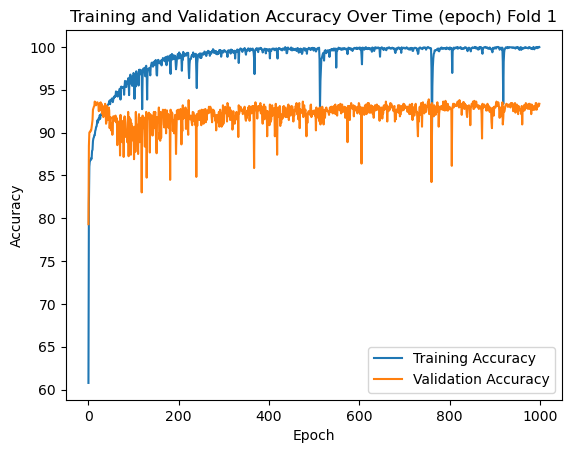

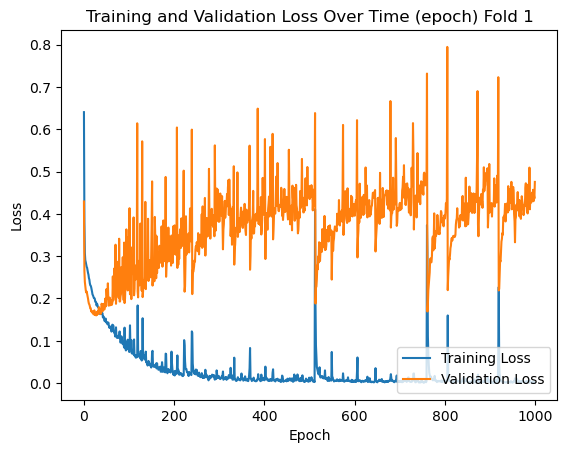

Exec Time : 66.05 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3407
False Positive : 0
False Negative : 0
True Negative : 1231

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumours Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[1231    0]
 [   0 3407]]


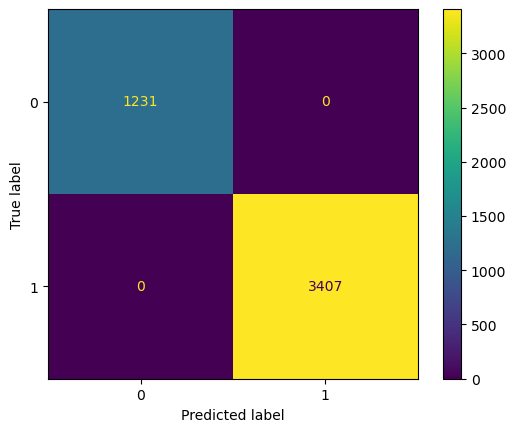


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 802
False Positive : 21
False Negative : 50
True Negative : 287

Class non-rumours Evaluation
- Precision : 97.448 %
- Recall : 94.131 %
- F1 : 0.95761

Class rumours Evaluation
- Precision : 85.163 %
- Recall : 93.182 %
- F1 : 0.88992

Combined Evaluation
- Accuracy : 93.879 %
- Precision : 91.306 %
- Recall : 93.657 %
- F1 : 0.92467
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1 Validation, 93.879, 91.306, 93.657, 0.92467, 97.448, 94.131, 0.95761, 85.163, 93.182, 0.88992, 
Confusion Matrix Scikit-learn: 
[[287  21]
 [ 50 802]]


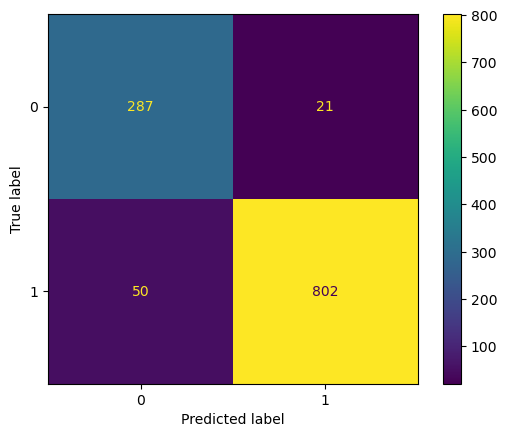


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 403
False Positive : 29
False Negative : 58
True Negative : 137

Class non-rumours Evaluation
- Precision : 93.287 %
- Recall : 87.419 %
- F1 : 0.90258

Class rumours Evaluation
- Precision : 70.256 %
- Recall : 82.53 %
- F1 : 0.759

Combined Evaluation
- Accuracy : 86.124 %
- Precision : 81.772 %
- Recall : 84.974 %
- F1 : 0.83342
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold1 Test, 86.124, 81.772, 84.974, 0.83342, 93.287, 87.419, 0.90258, 70.256, 82.53, 0.759, 
627
627
Confusion Matrix Scikit-learn: 
[[137  29]
 [ 58 403]]


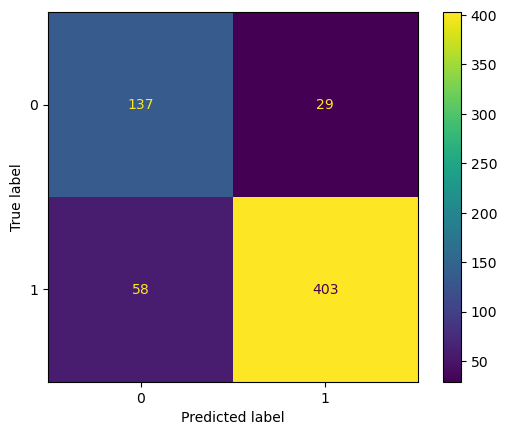

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 79.56896551724138
Saving after new best accuracy : 88.79310344827586
Saving after new best accuracy : 89.39655172413794
Saving after new best accuracy : 89.65517241379311
Saving after new best accuracy : 90.43103448275862
Saving after new best accuracy : 91.55172413793103
Saving after new best accuracy : 91.72413793103448
Saving after new best accuracy : 92.06896551724138
Saving after new best accuracy : 92.41379310344827
Saving after new best accuracy : 92.58620689655173
Saving after new best accuracy : 92.84482758620689
Saving after new best accuracy : 93.01724137931035
Saving after new best accuracy : 93.27586206896552
Saving after new best accuracy : 93.36206896551724
Saving after new best accuracy : 93.44827586206897
-- Epoch 50, Train_Accuracy : 93.29452350150927, Validation Accuracy : 92.41379310344827, Train Loss : 1.4808154348284006, Validation Loss : 0.5017909407615662
-- Epoch 100, Train_Accuracy : 96.50711513583441

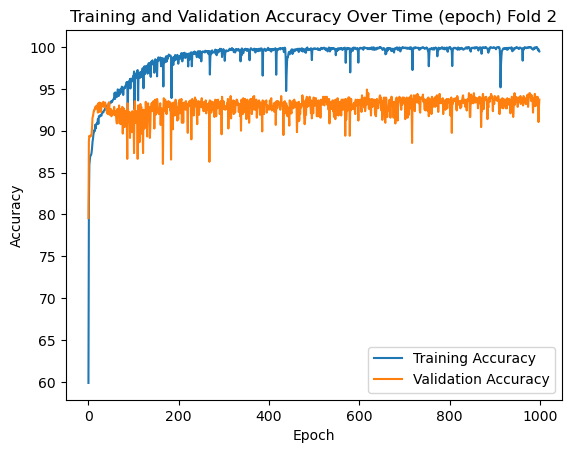

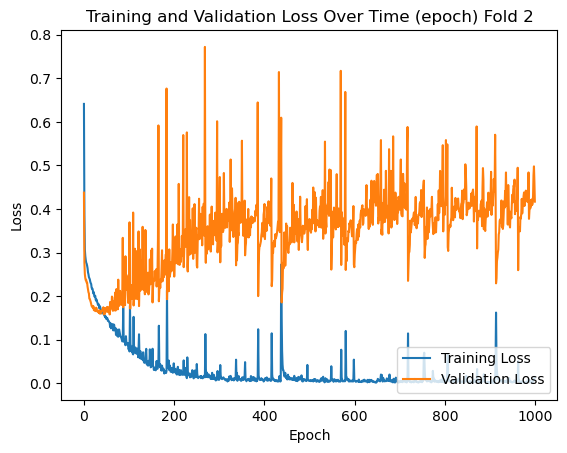

Exec Time : 63.06 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3404
False Positive : 0
False Negative : 3
True Negative : 1231

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 99.912 %
- F1 : 0.99956

Class rumours Evaluation
- Precision : 99.757 %
- Recall : 100.0 %
- F1 : 0.99878

Combined Evaluation
- Accuracy : 99.935 %
- Precision : 99.878 %
- Recall : 99.956 %
- F1 : 0.99917
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2 Train, 99.935, 99.878, 99.956, 0.99917, 100.0, 99.912, 0.99956, 99.757, 100.0, 0.99878, 
Confusion Matrix Scikit-learn: 
[[1231    0]
 [   3 3404]]


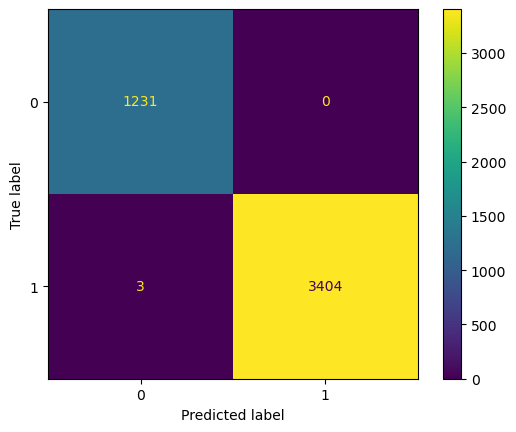


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 811
False Positive : 18
False Negative : 41
True Negative : 290

Class non-rumours Evaluation
- Precision : 97.829 %
- Recall : 95.188 %
- F1 : 0.9649

Class rumours Evaluation
- Precision : 87.613 %
- Recall : 94.156 %
- F1 : 0.90767

Combined Evaluation
- Accuracy : 94.914 %
- Precision : 92.721 %
- Recall : 94.672 %
- F1 : 0.93686
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2 Validation, 94.914, 92.721, 94.672, 0.93686, 97.829, 95.188, 0.9649, 87.613, 94.156, 0.90767, 
Confusion Matrix Scikit-learn: 
[[290  18]
 [ 41 811]]


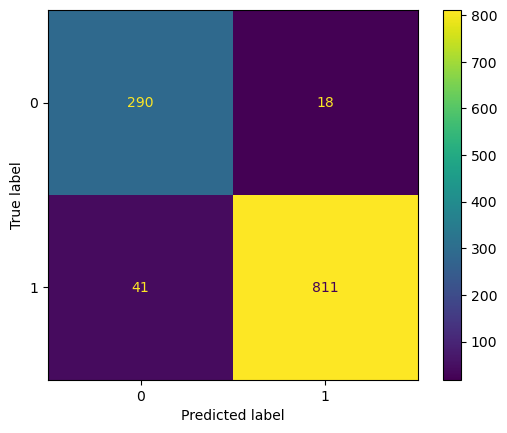


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 423
False Positive : 37
False Negative : 38
True Negative : 129

Class non-rumours Evaluation
- Precision : 91.957 %
- Recall : 91.757 %
- F1 : 0.91857

Class rumours Evaluation
- Precision : 77.246 %
- Recall : 77.711 %
- F1 : 0.77477

Combined Evaluation
- Accuracy : 88.038 %
- Precision : 84.601 %
- Recall : 84.734 %
- F1 : 0.84667
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold2 Test, 88.038, 84.601, 84.734, 0.84667, 91.957, 91.757, 0.91857, 77.246, 77.711, 0.77477, 
627
627
Confusion Matrix Scikit-learn: 
[[129  37]
 [ 38 423]]


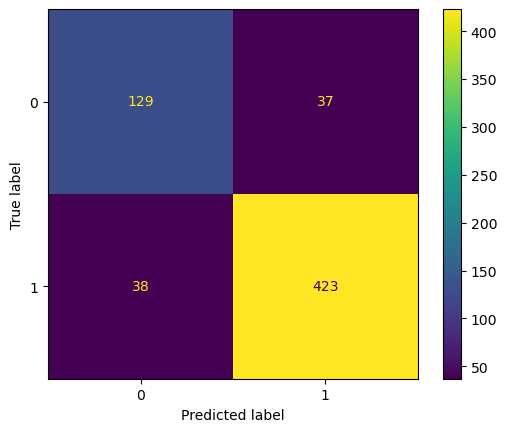

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 80.43103448275862
Saving after new best accuracy : 87.67241379310344
Saving after new best accuracy : 88.53448275862068
Saving after new best accuracy : 88.70689655172414
Saving after new best accuracy : 88.79310344827586
Saving after new best accuracy : 89.48275862068965
Saving after new best accuracy : 90.51724137931035
Saving after new best accuracy : 90.60344827586206
Saving after new best accuracy : 90.6896551724138
Saving after new best accuracy : 91.12068965517241
Saving after new best accuracy : 91.20689655172414
Saving after new best accuracy : 91.37931034482759
Saving after new best accuracy : 91.8103448275862
Saving after new best accuracy : 92.06896551724138
Saving after new best accuracy : 92.24137931034483
Saving after new best accuracy : 92.67241379310344
Saving after new best accuracy : 92.84482758620689
Saving after new best accuracy : 92.93103448275862
Saving after new best accuracy : 93.10344827586206
Saving

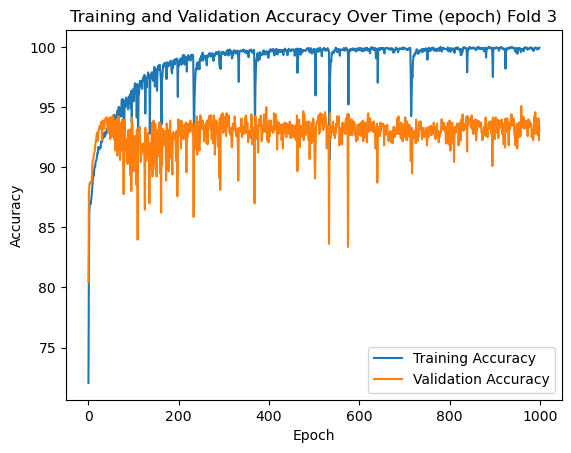

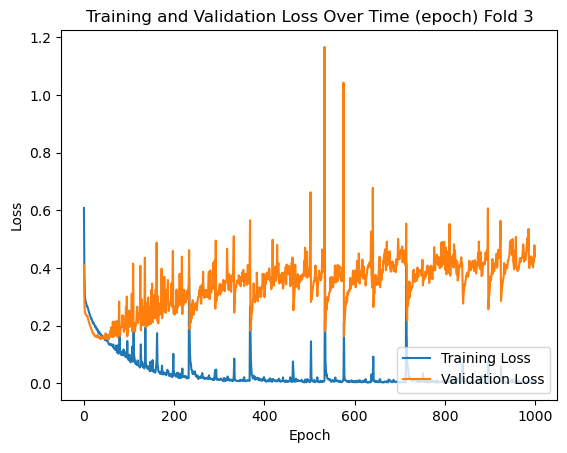

Exec Time : 59.61 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([4638])
Binary Class Evaluation

True Positive : 3399
False Positive : 0
False Negative : 8
True Negative : 1231

Class non-rumours Evaluation
- Precision : 100.0 %
- Recall : 99.765 %
- F1 : 0.99882

Class rumours Evaluation
- Precision : 99.354 %
- Recall : 100.0 %
- F1 : 0.99676

Combined Evaluation
- Accuracy : 99.828 %
- Precision : 99.677 %
- Recall : 99.883 %
- F1 : 0.9978
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3 Train, 99.828, 99.677, 99.883, 0.9978, 100.0, 99.765, 0.99882, 99.354, 100.0, 0.99676, 
Confusion Matrix Scikit-learn: 
[[1231    0]
 [   8 3399]]


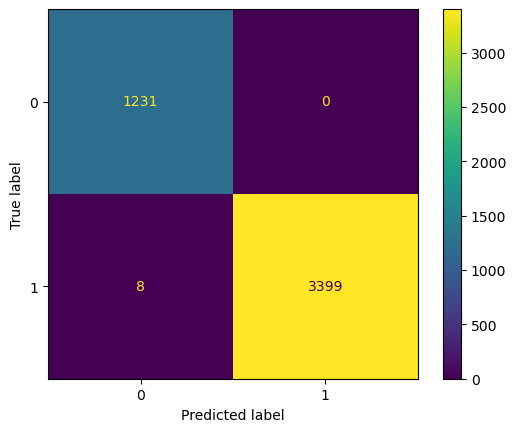


Validation Set
Predictions : torch.Size([1160])
Binary Class Evaluation

True Positive : 807
False Positive : 12
False Negative : 45
True Negative : 296

Class non-rumours Evaluation
- Precision : 98.535 %
- Recall : 94.718 %
- F1 : 0.96589

Class rumours Evaluation
- Precision : 86.804 %
- Recall : 96.104 %
- F1 : 0.91217

Combined Evaluation
- Accuracy : 95.086 %
- Precision : 92.669 %
- Recall : 95.411 %
- F1 : 0.9402
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3 Validation, 95.086, 92.669, 95.411, 0.9402, 98.535, 94.718, 0.96589, 86.804, 96.104, 0.91217, 
Confusion Matrix Scikit-learn: 
[[296  12]
 [ 45 807]]


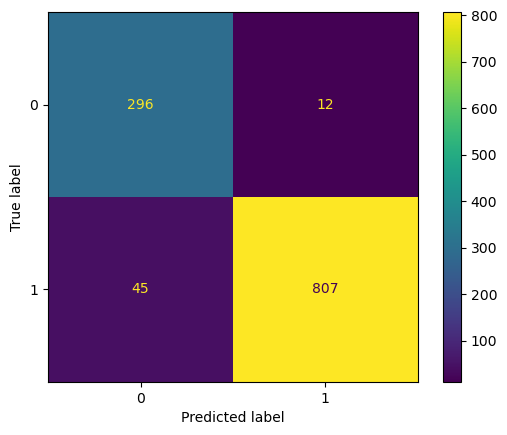


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 423
False Positive : 36
False Negative : 38
True Negative : 130

Class non-rumours Evaluation
- Precision : 92.157 %
- Recall : 91.757 %
- F1 : 0.91957

Class rumours Evaluation
- Precision : 77.381 %
- Recall : 78.313 %
- F1 : 0.77844

Combined Evaluation
- Accuracy : 88.198 %
- Precision : 84.769 %
- Recall : 85.035 %
- F1 : 0.84902
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold3 Test, 88.198, 84.769, 85.035, 0.84902, 92.157, 91.757, 0.91957, 77.381, 78.313, 0.77844, 
627
627
Confusion Matrix Scikit-learn: 
[[130  36]
 [ 38 423]]


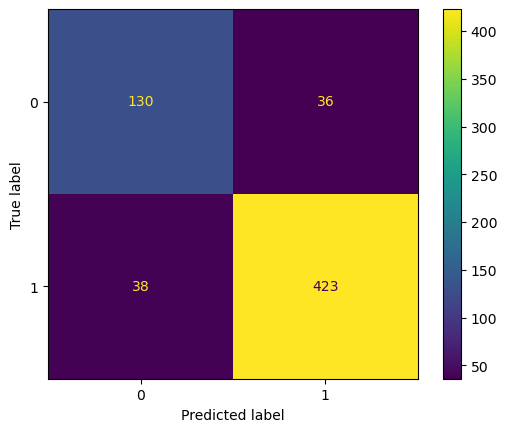

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 77.91199309749784
Saving after new best accuracy : 86.45383951682484
Saving after new best accuracy : 86.88524590163935
Saving after new best accuracy : 87.05780845556514
Saving after new best accuracy : 87.57549611734254
Saving after new best accuracy : 88.69715271786022
Saving after new best accuracy : 89.55996548748921
Saving after new best accuracy : 89.90509059534081
Saving after new best accuracy : 90.1639344262295
Saving after new best accuracy : 90.3364969801553
Saving after new best accuracy : 91.37187230371009
Saving after new best accuracy : 91.80327868852459
-- Epoch 50, Train_Accuracy : 93.79176546669541, Validation Accuracy : 91.1130284728214, Train Loss : 1.4491550289094448, Validation Loss : 0.685776099562645
Saving after new best accuracy : 92.49352890422779
-- Epoch 100, Train_Accuracy : 96.78810088381117, Validation Accuracy : 84.29680759275237, Train Loss : 0.7451606960967183, Validation Loss : 1.8980733454

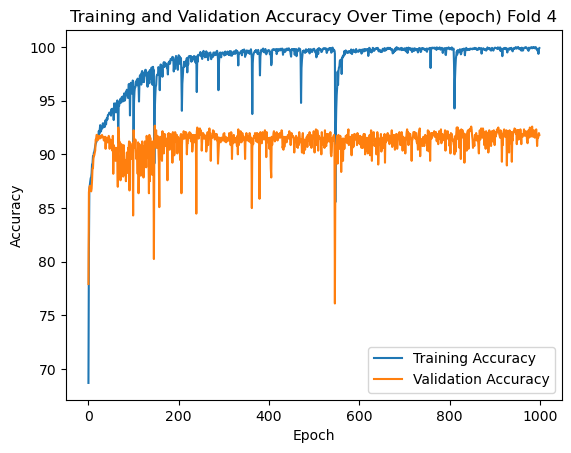

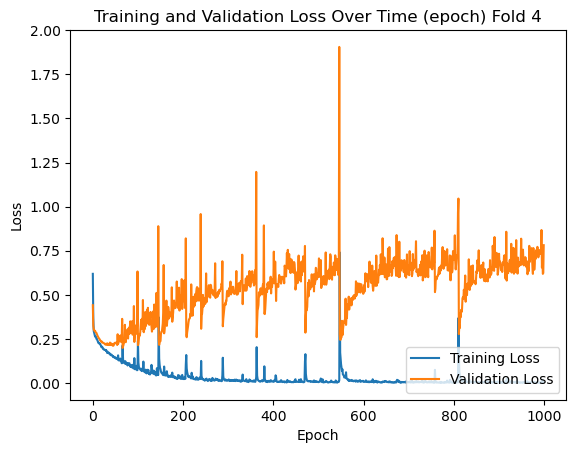

Exec Time : 60.08 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3283
False Positive : 59
False Negative : 124
True Negative : 1173

Class non-rumours Evaluation
- Precision : 98.235 %
- Recall : 96.36 %
- F1 : 0.97288

Class rumours Evaluation
- Precision : 90.439 %
- Recall : 95.211 %
- F1 : 0.92764

Combined Evaluation
- Accuracy : 96.055 %
- Precision : 94.337 %
- Recall : 95.786 %
- F1 : 0.95056
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4 Train, 96.055, 94.337, 95.786, 0.95056, 98.235, 96.36, 0.97288, 90.439, 95.211, 0.92764, 
Confusion Matrix Scikit-learn: 
[[1173   59]
 [ 124 3283]]


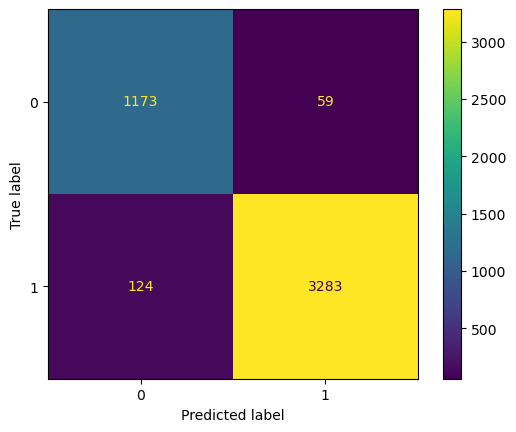


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 811
False Positive : 44
False Negative : 41
True Negative : 263

Class non-rumours Evaluation
- Precision : 94.854 %
- Recall : 95.188 %
- F1 : 0.95021

Class rumours Evaluation
- Precision : 86.513 %
- Recall : 85.668 %
- F1 : 0.86088

Combined Evaluation
- Accuracy : 92.666 %
- Precision : 90.683 %
- Recall : 90.428 %
- F1 : 0.90555
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4 Validation, 92.666, 90.683, 90.428, 0.90555, 94.854, 95.188, 0.95021, 86.513, 85.668, 0.86088, 
Confusion Matrix Scikit-learn: 
[[263  44]
 [ 41 811]]


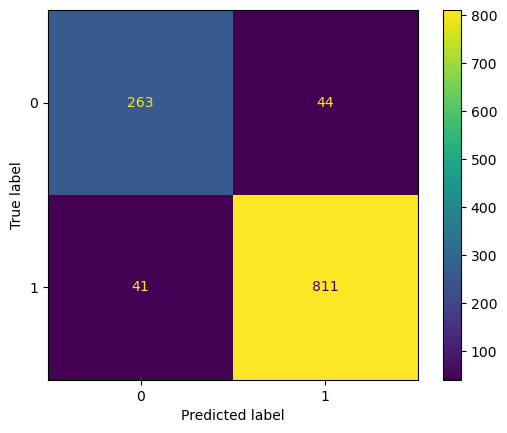


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 421
False Positive : 30
False Negative : 40
True Negative : 136

Class non-rumours Evaluation
- Precision : 93.348 %
- Recall : 91.323 %
- F1 : 0.92325

Class rumours Evaluation
- Precision : 77.273 %
- Recall : 81.928 %
- F1 : 0.79532

Combined Evaluation
- Accuracy : 88.836 %
- Precision : 85.31 %
- Recall : 86.625 %
- F1 : 0.85962
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold4 Test, 88.836, 85.31, 86.625, 0.85962, 93.348, 91.323, 0.92325, 77.273, 81.928, 0.79532, 
627
627
Confusion Matrix Scikit-learn: 
[[136  30]
 [ 40 421]]


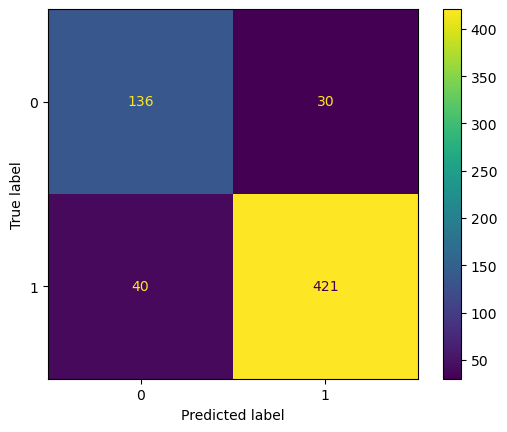

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 78.51596203623814
Saving after new best accuracy : 82.053494391717
Saving after new best accuracy : 82.1397756686799
Saving after new best accuracy : 82.3986194995686
Saving after new best accuracy : 83.17515099223469
Saving after new best accuracy : 83.34771354616048
Saving after new best accuracy : 83.60655737704919
Saving after new best accuracy : 84.29680759275237
Saving after new best accuracy : 84.64193270060397
Saving after new best accuracy : 85.33218291630716
Saving after new best accuracy : 85.41846419327005
Saving after new best accuracy : 85.59102674719585
Saving after new best accuracy : 86.45383951682484
Saving after new best accuracy : 87.05780845556514
-- Epoch 50, Train_Accuracy : 95.58094416900194, Validation Accuracy : 86.36755823986195, Train Loss : 1.0578308422118425, Validation Loss : 1.3903056383132935
Saving after new best accuracy : 87.23037100949094
Saving after new best accuracy : 87.31665228645385
S

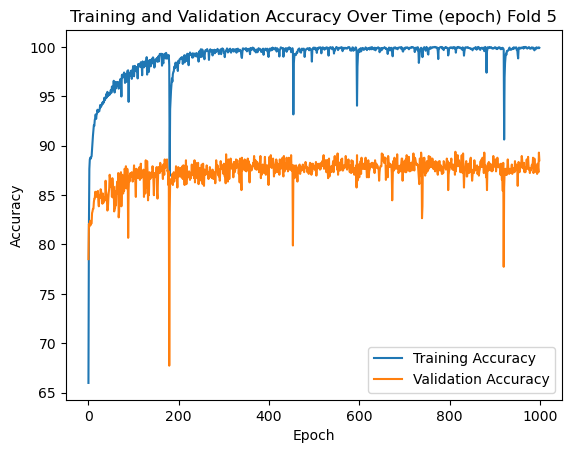

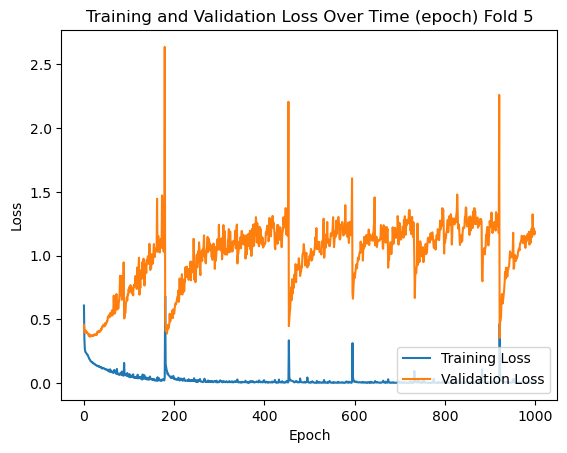

Exec Time : 59.72 seconds
loading model from ../../data/models/cross-validation/Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([4639])
Binary Class Evaluation

True Positive : 3408
False Positive : 1
False Negative : 0
True Negative : 1230

Class non-rumours Evaluation
- Precision : 99.971 %
- Recall : 100.0 %
- F1 : 0.99985

Class rumours Evaluation
- Precision : 100.0 %
- Recall : 99.919 %
- F1 : 0.99959

Combined Evaluation
- Accuracy : 99.978 %
- Precision : 99.985 %
- Recall : 99.959 %
- F1 : 0.99972
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5 Train, 99.978, 99.985, 99.959, 0.99972, 99.971, 100.0, 0.99985, 100.0, 99.919, 0.99959, 
Confusion Matrix Scikit-learn: 
[[1230    1]
 [   0 3408]]


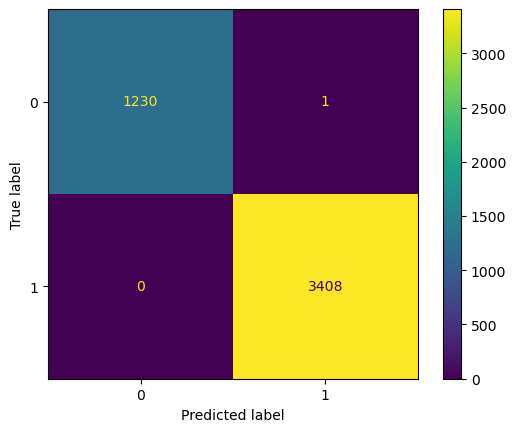


Validation Set
Predictions : torch.Size([1159])
Binary Class Evaluation

True Positive : 800
False Positive : 72
False Negative : 51
True Negative : 236

Class non-rumours Evaluation
- Precision : 91.743 %
- Recall : 94.007 %
- F1 : 0.92861

Class rumours Evaluation
- Precision : 82.23 %
- Recall : 76.623 %
- F1 : 0.79328

Combined Evaluation
- Accuracy : 89.387 %
- Precision : 86.987 %
- Recall : 85.315 %
- F1 : 0.86143
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5 Validation, 89.387, 86.987, 85.315, 0.86143, 91.743, 94.007, 0.92861, 82.23, 76.623, 0.79328, 
Confusion Matrix Scikit-learn: 
[[236  72]
 [ 51 800]]


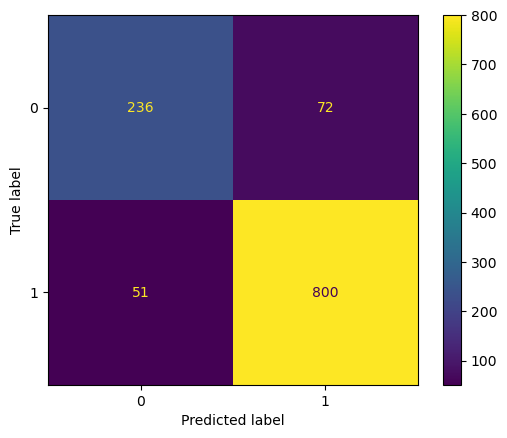


Test Set
Predictions : torch.Size([627])
Binary Class Evaluation

True Positive : 437
False Positive : 47
False Negative : 24
True Negative : 119

Class non-rumours Evaluation
- Precision : 90.289 %
- Recall : 94.794 %
- F1 : 0.92487

Class rumours Evaluation
- Precision : 83.217 %
- Recall : 71.687 %
- F1 : 0.77023

Combined Evaluation
- Accuracy : 88.676 %
- Precision : 86.753 %
- Recall : 83.24 %
- F1 : 0.8496
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,rumours,,,
Phemernr2-RNR_4LayerNet_L2Reg_BERT_Finetuned_Fold5 Test, 88.676, 86.753, 83.24, 0.8496, 90.289, 94.794, 0.92487, 83.217, 71.687, 0.77023, 
627
627
Confusion Matrix Scikit-learn: 
[[119  47]
 [ 24 437]]


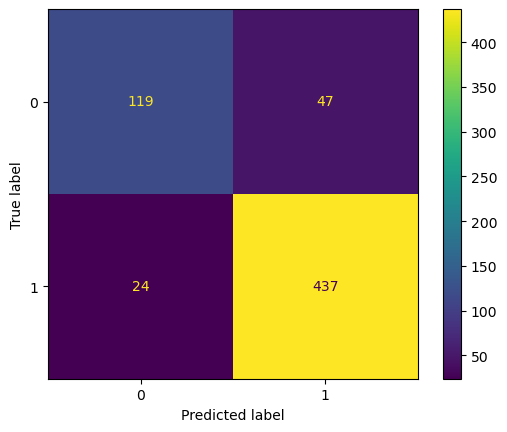

In [13]:
print("Multiclass Classification using 4-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()